ROI Classification
--
Info about classes:  
This scripts includes a pretrained model to classify ROIs as one of the following categories:
- **Label 0:** Neuron + In-plane ("Great")
- **Label 1:** Neuron + Semi-in-plane ("Okay")
- **Label 4:** Neuron + Out of plane ("Poor")
- **Label 5:** Dendrite

(*note that during the manual labeling, 0-5 is actually 1-6*)  <br>
(*label 2 is for weird blobs and shadows of neurons*)  <br>
(*label 3 is empty on purpose*)  <br>
___

Info about neural network:  
The network is trained on ~4700 ROIs from one FOV  
(mouse 6.28 , recorded on 20200903)  
- **Net_ROIClassifier_20200917.pth** state_dict file must be in path
- This script is specifically for the above .pth parameters file. Changes to the architecture cannot be made here.
___

Input data requirements:
---
- 36x36 images
- dim1: image number
- dim 2,3: y,x
- should be normalized between 0-1  


- **There are cell blocks to use the 'stat.npy' output from Suite2p and convert to the required format**


- Full FOV size (in pixels) should be known. Default=512x1024
___



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# import sys
# import copy

import numpy as np

import scipy
import scipy.signal
from scipy.io import savemat

import matplotlib.pyplot as plt

import sys

import pathlib

In [6]:
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

Autodetected operating system: Linux. Using "/" for directory slashes


In [7]:
## lOAD & PREPROCESS stat.npy file
## outputs: 'images' (input into CNN)

dir_load = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 6.28/20201102/suite2p/plane0'
fileName_load = 'stat.npy'

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/ROI_Classifiers/label data/mouse 6_28 _ day 20200903/'
path_load = f'{dir_load}{slash_type}{fileName_load}'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_ mouse2_5 _ 20200308/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/label data/mouse 6_28 _ day 20200903/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_mouse6_28 _ 20200815/'
print(path_load)

/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 6.28/20201102/suite2p/plane0/stat.npy


stat file loaded
Number of ROIs: 4817


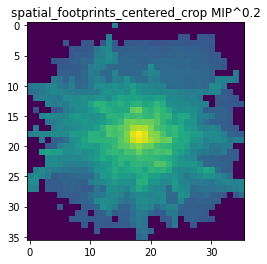

In [8]:
stat = np.load(path_load, allow_pickle=True)
print('stat file loaded')

num_ROI = stat.shape[0]
print(f'Number of ROIs: {num_ROI}')

height = 512
width = 1024
spatial_footprints_centered = np.zeros((num_ROI, 241,241))
for i in range(num_ROI):
    spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

%matplotlib inline
plt.figure()
plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
plt.title('spatial_footprints_centered_crop MIP^0.2');

images = spatial_footprints_centered_crop

In [9]:
## Define model architecture
## DO NOT CHANGE ANYTHING HERE!!!
## This architecture is linked to the .pth parameters file

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, PReLU, Softplus, Softmax2d
from torch.optim import Adam, SGD

dropout_prob = 0
momentum_val = 0.9

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(1, 6, kernel_size=4, stride=1, padding=0),
            BatchNorm2d(6, momentum=momentum_val),
            Dropout(dropout_prob*0.3),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(6, 64, kernel_size=4, stride=1, padding=0),
            Dropout(dropout_prob*1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(64, 128, kernel_size=4, stride=1, padding=0),
            BatchNorm2d(128, momentum=momentum_val),
            Dropout(dropout_prob*1),
            GELU(),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(128, 128),
            GELU(),
            Linear(128, 128),
            GELU(),
            Linear(128, 128),
            GELU(),
            Sigmoid(),
            Linear(128, 6),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = self.linear_layers(x)
        return x 

In [10]:
dropout_prob = 0.0
momentum_val = 0.9

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            BatchNorm2d(1, momentum=momentum_val),
            Conv2d(1, 6, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(6, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
            MaxPool2d(kernel_size=2, stride=2),
            
           # Defining a 2D convolution layer
            Conv2d(6, 16, kernel_size=4, stride=1, padding=2),
            BatchNorm2d(16, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
            MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            Conv2d(16, 64, kernel_size=4, stride=1, padding=2),
            BatchNorm2d(64, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
#             Softmax2d(),
            MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=4, stride=1, padding=2),
#             BatchNorm2d(16, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
#             Softmax2d(),
            MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(64, 64, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            Conv2d(64, 16, kernel_size=4, stride=1, padding=2),
#             BatchNorm2d(16, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
#             Softmax2d(),
            MaxPool2d(kernel_size=2, stride=2),

        )

        self.linear_layers = Sequential(
            
            Linear(64, 16),
            Dropout(dropout_prob * 1),
            SELU(),
#             Softmax(dim=0),
#             Sigmoid(),
            
            
            Linear(16, 64),
            Dropout(dropout_prob * 1),
            SELU(),

            Linear(64, 6),
#             ReLU(),
#             Softmax(dim=0),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
# #         x = x.view(x.size(0), -1)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
        x = self.linear_layers(x)
        return x 

In [12]:
#### ENTER FILENAME + PATH OF NETWORK .pth FILE

PATH_load_name_netParams = 'ROI_Classifier 20200922/Net_trainedOnAug_20200922_trainingSet20200903.pth'
# PATH_load_dir_netParams = 'G:/My Drive/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/'
PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_netParams = f'{PATH_absolute}/'

model = Net()
model.load_state_dict(torch.load(f'{PATH_load_dir_netParams}{PATH_load_name_netParams}'))
model.eval()

Net(
  (cnn_layers): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (3): SELU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (7): SELU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(16, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (11): SELU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (14): SE

In [13]:
input_x = torch.tensor(images[:,None,:,:]).type('torch.FloatTensor')

output = model(input_x).cpu().detach().numpy()
softmax = np.exp(output)
prob = softmax
predictions = np.argmax(list(prob), axis=1)


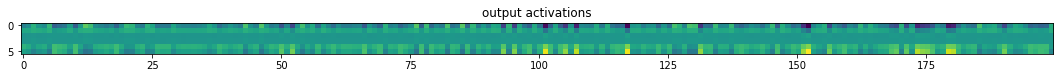

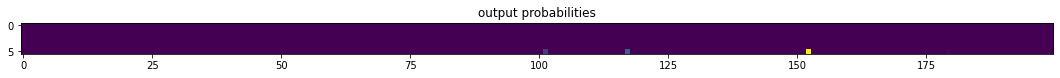

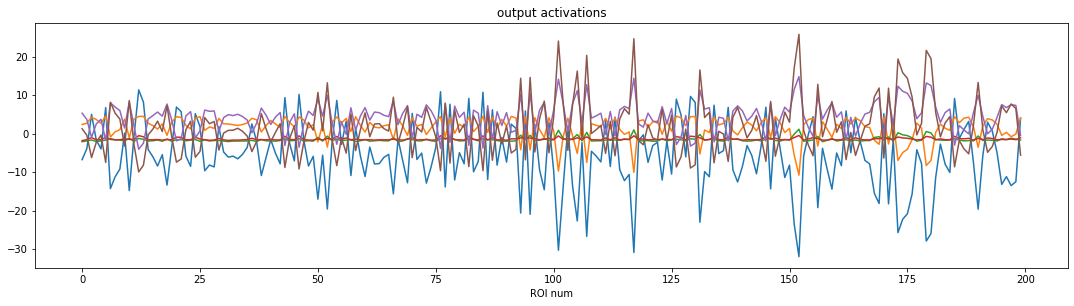

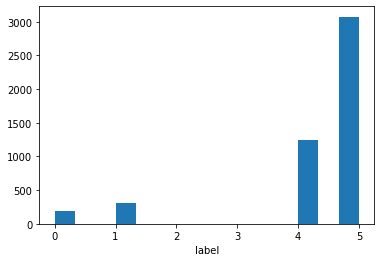

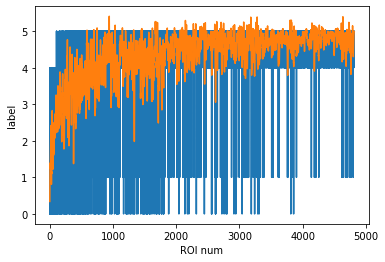

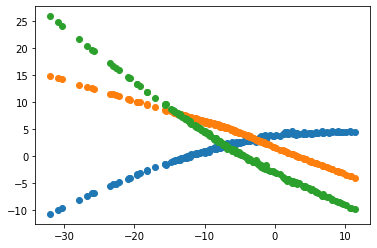

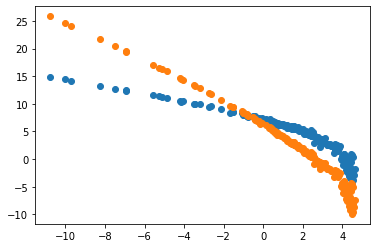

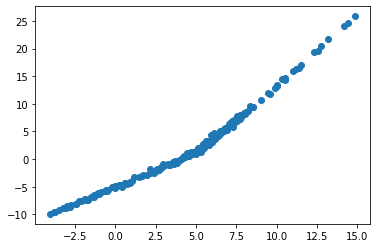

In [14]:
## Show some of the results

ind_to_plot =np.arange(100,300)

%matplotlib inline
fig_output = plt.figure()
plt.imshow(output[ind_to_plot,:].T);
plt.title('output activations');
fig_output.set_size_inches(18.5, 10.5)

fig_prob = plt.figure()
plt.imshow(prob[ind_to_plot,:].T);
plt.title('output probabilities');
fig_prob.set_size_inches(18.5, 10.5)

fig_prob_lines = plt.figure()
plt.plot(output[ind_to_plot,:])
plt.title('output activations');
plt.xlabel('ROI num')
fig_prob_lines.set_size_inches(18.5, 4.5)

fig_predHist = plt.figure()
plt.hist(predictions , 15);
plt.xlabel('label')

fig_predLines = plt.figure()
plt.plot(predictions);
plt.plot(scipy.signal.savgol_filter(predictions,19,3));
plt.xlabel('ROI num')
plt.ylabel('label')

fig_scatterGroups0 = plt.figure()
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([1])])
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([4])])
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([5])])
fig_scatterGroups1 = plt.figure()
plt.scatter(output[ind_to_plot , np.array([1])] , output[ind_to_plot , np.array([4])])
plt.scatter(output[ind_to_plot , np.array([1])] , output[ind_to_plot , np.array([5])])
fig_scatterGroups4 = plt.figure()
plt.scatter(output[ind_to_plot , np.array([4])] , output[ind_to_plot , np.array([5])])

KeyboardInterrupt: Interrupted by user

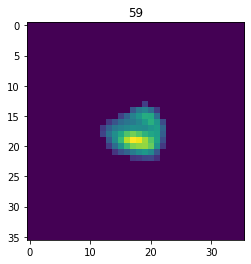

In [16]:
## UNCOMMENT to Look at individual cells


## Press ENTER to advance. Press 9 to exit

class_to_test = 1



%matplotlib qt
plt.figure()
plt.pause(0.5) 
input_val = 0
iter_start = 0
while np.int8(input_val) < 7:
    for ii in np.where(predictions ==class_to_test)[0]:
        if ii >= iter_start:
            plt.imshow(images[ii, : , :])
            plt.title(ii)
            plt.show(block=False)
            plt.pause(0.05) 
            input_val = input()
            if not input_val:
                continue
            if np.int8(input_val) >=7:
                break
            plt.pause(0.05) 

## Save data as a .mat file (for CellReg or whatever)

# PATH_save_dir = 'G:/My Drive/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/'
PATH_absolute = pathlib.Path('.').absolute()
PATH_save_dir = f'{PATH_absolute}/'
PATH_save_name = 'outputs_CNN.mat'

outputs_CNN = dict()
outputs_CNN = {
    'CNN_outputs_raw': output ,
    'CNN_probabilities': prob ,
    'CNN_predictions': predictions}

scipy.io.savemat(f'{PATH_save_dir}{PATH_save_name}' , outputs_CNN)

In [19]:

num_ROI = data_posthoc_test.shape[0]


labels_posthoc = np.zeros(num_ROI)

NameError: name 'data_posthoc_test' is not defined

In [ ]:
# %matplotlib qt
plt.figure()
# plt.imshow(spatial_footprints_crop[: , : , 0])
plt.pause(0.5) 
input_val = 0
iter_start = 440
num_ROI = images.shape[0]

while np.int8(input_val) < 7:
    for ii in np.where(labels_extrapolated ==0)[0]:
        if ii >= iter_start:
#             print(ii)

            plt.imshow(images[ii, : , :])
            plt.title(ii)
            plt.show(block=False)
            plt.pause(0.15) 

            input_val = input()

            if not input_val:
                continue
            if np.int8(input_val) >=7:
                break
            if input_val:
                labels_posthoc[ii] = np.int8(input_val)
            plt.pause(0.15) 
#             print(f'Num labeled: {ii}')
    

In [ ]:
# %matplotlib inline
plt.figure()
plt.plot(labels_posthoc)
plt.figure()
plt.hist(labels_posthoc[labels_posthoc > 0]);

In [ ]:
labels_posthoc_indOfCorrected_bool = labels_posthoc > 0
labels_posthoc_filledIn = copy.deepcopy(labels_extrapolated)
labels_posthoc_filledIn[labels_posthoc_indOfCorrected_bool] = labels_posthoc[labels_posthoc_indOfCorrected_bool] -1
plt.figure()
plt.plot(labels_posthoc_filledIn)
plt.figure()
plt.hist(labels_posthoc_filledIn,20);

In [ ]:
# np.save('labels_posthoc_filledIn.npy',labels_posthoc_filledIn)
# np.save('labels_posthoc.npy',labels_posthoc)